In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression # untuk  pemodelan dengan logistic regression
from sklearn.neighbors import KNeighborsClassifier # untuk pemodelan dengan K Neighbors Classifier 
from sklearn.ensemble import RandomForestClassifier # untuk pemodelan dengan Random Forest Classifier
from sklearn.tree import DecisionTreeClassifier # untuk pemodelan dengan Decision Tree Classifier
from sklearn.svm import SVC # untuk pemodelan dengan Support Vector Machine dengan tipe Classification
from xgboost import XGBClassifier # untuk pemodelan dengan XGBoost (Extreme Gradient Boosting) untuk tipe Classification
from sklearn.ensemble import  AdaBoostClassifier # untuk pemodelan dengan Adaptive Boosting untuk tipe Classification

from sklearn.model_selection import train_test_split # untuk spliting dataset menjadi train dan test sebagai bagian pemodelan
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, recall_score, precision_score # untuk analisis akurasi, F1, recall, dan precision jika analisis dengan classification report mengalami masalah
from sklearn.metrics import classification_report, confusion_matrix # mengimport package tentang classification report dan confusion matrix
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, auc # ROC : receiver operating characteristic; AUC = Area under curve; Hindari AUC bernilai 0.5 ke bawah; 0.7 sudah bagus
import statsmodels.api as sm # mengimport package tentang statsmodels untuk analisa sebuah model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler, MinMaxScaler, StandardScaler # mengimport package tentang scaling sebagai bagian dari feature engineering

from sklearn.model_selection import GridSearchCV # mengimport package tentang GridSearchCV untuk hyper parameter tuning dan cross validation (CV)

# untuk mempermudah pemodelan dengan data yang berkategori numerical dan categorical, pipeline dapat digunakan.
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# Jika data bersifat imbalanced, beberapa package berikut dapat diimport untuk meng-handle imbalanced data
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer

# Untuk mengekspor dataset ke dashboard
import pickle
import joblib

%matplotlib inline

pd.options.display.max_columns = 999 # biar koloom tidak ada titik2, ditampilkan semua
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format='{:,}'.format

In [2]:
df = pd.read_csv("C:/Users/ASUS/visual_studio_code/final_project/dataset/bank-additional-full.csv")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no


#### Input variables:
#### bank client data:
- **age** (numeric)
- **job** : tipe pekerjaan (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
- **marital** : status pernikahan (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
- **Education** : pendidikan (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
- **default** : apakah ada credit yang default? (categorical: "no","yes","unknown")
- **housing** : apakah punya pinjaman rumah? (categorical: "no","yes","unknown")
- **loan** : apakah punya pinjaman pribadi ? (categorical: "no","yes","unknown")

#### Berhubungan dengan kontak terakhir dari campaign saat ini:
- **contact** :  tipe komunikasi kontak (categorical: "cellular","telephone") 
- **month** : kontak terakhir pada bulan apa di tahun tersebut (categorical: "jan", "feb", "mar", ..., "nov", "dec")
- **day_of_week** :  kontak terakhir pada hari apa di minggu tersebut (categorical: "mon","tue","wed","thu","fri")
- **duration** : durasi kontak terakhir, dalam detik (numeric). Catatan penting : atribut ini sangat mempengaruhi target output (contoh, jika duration=0 maka y="no"). Namun, duration tidak diketahui sebelum pemanggilan dilakukan. Selain itu, setelah pemanggilan berakhir, status y menjadi jelas. Maka, atribut ini hanya diikutsertakan untuk tujuan benchmark dan sebaiknya dibuang jika tujuan analisis adalah pembuatan model prediktif yang realistik.  

#### Atribut lain: 
- **campaign** : jumlah kontak yang dilakukan selama campaign saat ini berlangsung dan untuk client tersebut (numeric, termasuk kontak terakhir)
- **pdays** : jumlah hari yang telah berlalu setelah client dikontak terakhir kali dari campaign sebelumnya (numeric; 999 berarti client tidak dikontak sebelumnya)
- **previous** : jumlah kontak yang dilakukan sebelum campaign ini dan untuk client tersebut (numeric)
- **poutcome** : hasil dari marketing campaign sebelumnya (categorical: "failure","nonexistent","success")

#### Atribut dalam konteks sosial dan ekonomik: 
- **emp.var.rate** : employment variation rate - quarterly indicator (numeric)
- **cons.price.idx** : consumer price index - monthly indicator (numeric)     
- **cons.conf.idx** : consumer confidence index - monthly indicator (numeric)     
- **euribor3m** : euribor 3 month rate - daily indicator (numeric)
- **nr.employed** : number of employees - quarterly indicator (numeric)

#### Output variable (target yang diinginkan):
- **y** – apakah client mendaftarkan term deposit? (binary: "yes","no")

In [3]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,"41,188.0","41,188.0","41,188.0","41,188.0","41,188.0","41,188.0","41,188.0","41,188.0","41,188.0","41,188.0"
mean,40.02406040594348,258.2850101971448,2.567592502670681,962.4754540157328,0.17296299893172767,0.08188550063125165,93.5756643682626,-40.50260027192386,3.621290812858114,"5,167.035910944936"
std,10.421249980934048,259.2792488364648,2.7700135429023276,186.9109073447418,0.4949010798392897,1.5709597405170255,0.578840048954127,4.628197856174544,1.734447404851267,72.25152766826108
min,17.0,0.0,1.0,0.0,0.0,-3.4,92.20100000000001,-50.8,0.634,"4,963.6"
25%,32.0,102.0,1.0,999.0,0.0,-1.8,93.075,-42.7,1.344,"5,099.1"
50%,38.0,180.0,2.0,999.0,0.0,1.1,93.749,-41.8,4.857,"5,191.0"
75%,47.0,319.0,3.0,999.0,0.0,1.4,93.994,-36.4,4.961,"5,228.1"
max,98.0,"4,918.0",56.0,999.0,7.0,1.4,94.76700000000001,-26.9,5.045,"5,228.1"


In [5]:
df.describe(include='O')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [4]:
df.info() # Dataset mengandung 20 kolom dan 371539 baris

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [6]:
df['y'].unique()

array(['no', 'yes'], dtype=object)

In [9]:
df[df['y'] == 'no']['y'].count()

36548

In [5]:
df[(df['y'] == 'no') & (df['duration'] == 0)]['y'].count()

4

In [6]:
df[(df['y'] == 'no') & (df['duration'] != 0)]['y'].count()

36544

In [4]:
df[df['y'] == 'yes']['y'].count()

4640

In [7]:
df[(df['y'] == 'yes') & (df['duration'] != 0)]['y'].count()

4640

In [10]:
df[df['duration'] == 0]['y'].count()

4

In [17]:
df[df['duration'] == 0]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
6251,39,admin.,married,high.school,no,yes,no,telephone,may,tue,0,4,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
23031,59,management,married,university.degree,no,yes,no,cellular,aug,tue,0,10,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
28063,53,blue-collar,divorced,high.school,no,yes,no,cellular,apr,fri,0,3,999,0,nonexistent,-1.8,93.075,-47.1,1.479,5099.1,no
33015,31,blue-collar,married,basic.9y,no,no,no,cellular,may,mon,0,2,999,0,nonexistent,-1.8,92.893,-46.2,1.299,5099.1,no


In [11]:
df[df['duration'] != 0]['y'].count()

41184

In [6]:
df[df['pdays']!= 999]['pdays'].count()

1515

In [9]:
df[(df['pdays']!= 999) & (df['y'] == 'no')]['y'].count()

548

In [10]:
df[(df['pdays']!= 999) & (df['y'] == 'yes')]['y'].count()

967

In [4]:
df['age'].unique()

array([56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 54, 46, 50, 39, 30, 55,
       49, 34, 52, 58, 32, 38, 44, 42, 60, 53, 47, 51, 48, 33, 31, 43, 36,
       28, 27, 26, 22, 23, 20, 21, 61, 19, 18, 70, 66, 76, 67, 73, 88, 95,
       77, 68, 75, 63, 80, 62, 65, 72, 82, 64, 71, 69, 78, 85, 79, 83, 81,
       74, 17, 87, 91, 86, 98, 94, 84, 92, 89], dtype=int64)

In [5]:
df['job'].unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

In [6]:
df['marital'].unique()

array(['married', 'single', 'divorced', 'unknown'], dtype=object)

In [7]:
df['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

In [8]:
df['default'].unique()

array(['no', 'unknown', 'yes'], dtype=object)

In [9]:
df['housing'].unique()

array(['no', 'yes', 'unknown'], dtype=object)

In [10]:
df['loan'].unique()

array(['no', 'yes', 'unknown'], dtype=object)

In [11]:
df['contact'].unique()

array(['telephone', 'cellular'], dtype=object)

In [12]:
df['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr',
       'sep'], dtype=object)

In [13]:
df['day_of_week'].unique()

array(['mon', 'tue', 'wed', 'thu', 'fri'], dtype=object)

In [14]:
df['duration'].unique()

array([ 261,  149,  226, ..., 1246, 1556, 1868], dtype=int64)

In [21]:
df['duration'].sort_values().unique()

array([   0,    1,    2, ..., 3785, 4199, 4918], dtype=int64)

In [16]:
df['campaign'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 19, 18, 23, 14,
       22, 25, 16, 17, 15, 20, 56, 39, 35, 42, 28, 26, 27, 32, 21, 24, 29,
       31, 30, 41, 37, 40, 33, 34, 43], dtype=int64)

In [17]:
df['pdays'].unique()

array([999,   6,   4,   3,   5,   1,   0,  10,   7,   8,   9,  11,   2,
        12,  13,  14,  15,  16,  21,  17,  18,  22,  25,  26,  19,  27,
        20], dtype=int64)

In [18]:
df['previous'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [19]:
df['poutcome'].unique()

array(['nonexistent', 'failure', 'success'], dtype=object)

In [20]:
df['emp.var.rate'].unique()

array([ 1.1,  1.4, -0.1, -0.2, -1.8, -2.9, -3.4, -3. , -1.7, -1.1])

In [21]:
df['cons.price.idx'].unique()

array([93.994, 94.465, 93.918, 93.444, 93.798, 93.2  , 92.756, 92.843,
       93.075, 92.893, 92.963, 92.469, 92.201, 92.379, 92.431, 92.649,
       92.713, 93.369, 93.749, 93.876, 94.055, 94.215, 94.027, 94.199,
       94.601, 94.767])

In [22]:
df['cons.conf.idx'].unique()

array([-36.4, -41.8, -42.7, -36.1, -40.4, -42. , -45.9, -50. , -47.1,
       -46.2, -40.8, -33.6, -31.4, -29.8, -26.9, -30.1, -33. , -34.8,
       -34.6, -40. , -39.8, -40.3, -38.3, -37.5, -49.5, -50.8])

In [23]:
df['euribor3m'].unique()

array([4.857, 4.856, 4.855, 4.859, 4.86 , 4.858, 4.864, 4.865, 4.866,
       4.967, 4.961, 4.959, 4.958, 4.96 , 4.962, 4.955, 4.947, 4.956,
       4.966, 4.963, 4.957, 4.968, 4.97 , 4.965, 4.964, 5.045, 5.   ,
       4.936, 4.921, 4.918, 4.912, 4.827, 4.794, 4.76 , 4.733, 4.7  ,
       4.663, 4.592, 4.474, 4.406, 4.343, 4.286, 4.245, 4.223, 4.191,
       4.153, 4.12 , 4.076, 4.021, 3.901, 3.879, 3.853, 3.816, 3.743,
       3.669, 3.563, 3.488, 3.428, 3.329, 3.282, 3.053, 1.811, 1.799,
       1.778, 1.757, 1.726, 1.703, 1.687, 1.663, 1.65 , 1.64 , 1.629,
       1.614, 1.602, 1.584, 1.574, 1.56 , 1.556, 1.548, 1.538, 1.531,
       1.52 , 1.51 , 1.498, 1.483, 1.479, 1.466, 1.453, 1.445, 1.435,
       1.423, 1.415, 1.41 , 1.405, 1.406, 1.4  , 1.392, 1.384, 1.372,
       1.365, 1.354, 1.344, 1.334, 1.327, 1.313, 1.299, 1.291, 1.281,
       1.266, 1.25 , 1.244, 1.259, 1.264, 1.27 , 1.262, 1.26 , 1.268,
       1.286, 1.252, 1.235, 1.224, 1.215, 1.206, 1.099, 1.085, 1.072,
       1.059, 1.048,

In [24]:
df['nr.employed'].unique()

array([5191. , 5228.1, 5195.8, 5176.3, 5099.1, 5076.2, 5017.5, 5023.5,
       5008.7, 4991.6, 4963.6])

In [17]:
dfDesc = []

for i in df.columns:
    dfDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum()) / (len(df))) * 100),2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

In [18]:
pd.DataFrame(dfDesc, columns = ['dataFeatures', 'dataType', 'null', 'nullPecentage', 'unique', 'uniquesample'])

,dataFeatures,dataType,null,nullPecentage,unique,uniquesample
0,age,int64,0,0.0,78,"[81, 44]"
1,job,object,0,0.0,12,"[blue-collar, retired]"
2,marital,object,0,0.0,4,"[divorced, married]"
3,education,object,0,0.0,8,"[professional.course, unknown]"
4,default,object,0,0.0,3,"[no, yes]"
5,housing,object,0,0.0,3,"[yes, no]"
6,loan,object,0,0.0,3,"[no, unknown]"
7,contact,object,0,0.0,2,"[telephone, cellular]"
8,month,object,0,0.0,10,"[apr, jul]"
9,day_of_week,object,0,0.0,5,"[thu, tue]"


# Exploratory Data Analysis

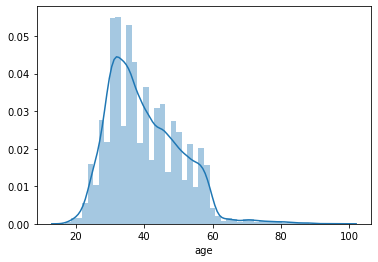

In [24]:
sns.distplot(df['age'])

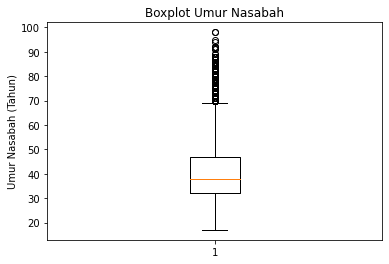

In [10]:
x = df['age']
plt.boxplot(x)
plt.title("Boxplot Umur Nasabah")
plt.ylabel("Umur Nasabah (Tahun)")
plt.show()

In [35]:
(df['age'].describe()).round(2)

count   41,188.0
mean       40.02
std        10.42
min         17.0
25%         32.0
50%         38.0
75%         47.0
max         98.0
Name: age, dtype: float64

In [9]:
df[df['age']> 69]['age'].count() # jumlah data outliers dengan umur di atas 69 tahun

469

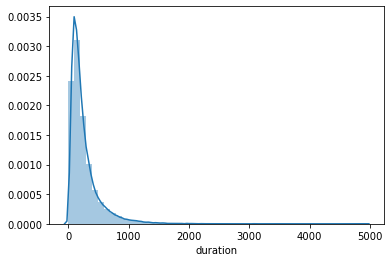

In [3]:
sns.distplot(df['duration'])

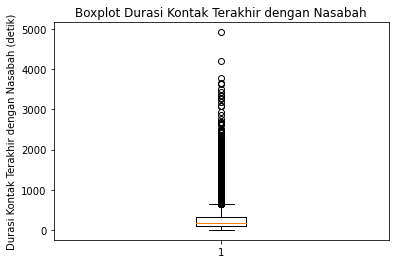

In [8]:
x = df['duration']
plt.boxplot(x)
plt.title("Boxplot Durasi Kontak Terakhir dengan Nasabah")
plt.ylabel("Durasi Kontak Terakhir dengan Nasabah (detik)")
plt.show()

In [34]:
(df['duration'].describe()).round(2)

count   41,188.0
mean      258.29
std       259.28
min          0.0
25%        102.0
50%        180.0
75%        319.0
max      4,918.0
Name: duration, dtype: float64

In [10]:
df[df['duration']> 644]['duration'].count() # jumlah data outliers nasabah dengan durasi kontak marketing di atas 644 detik

2963

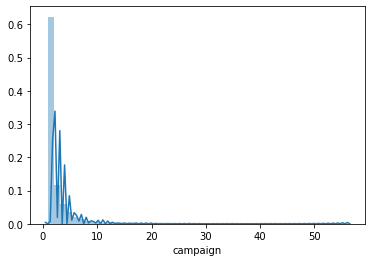

In [4]:
sns.distplot(df['campaign'])

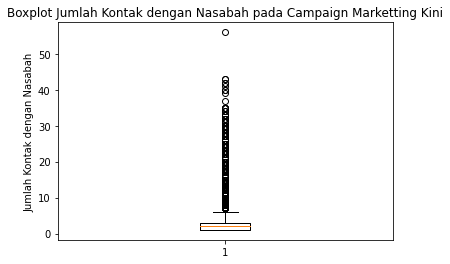

In [13]:
x = df['campaign']
plt.boxplot(x)
plt.title("Boxplot Jumlah Kontak dengan Nasabah pada Campaign Marketting Kini")
plt.ylabel("Jumlah Kontak dengan Nasabah")
plt.show()

In [36]:
(df['campaign'].describe()).round(2)

count   41,188.0
mean        2.57
std         2.77
min          1.0
25%          1.0
50%          2.0
75%          3.0
max         56.0
Name: campaign, dtype: float64

In [11]:
df[df['campaign']> 6]['campaign'].count() # jumlah data outliers nasabah dengan jumlah kontak terhitung selama campaign marketing yang sedang berlangsung saat ini di atas 6

2406

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


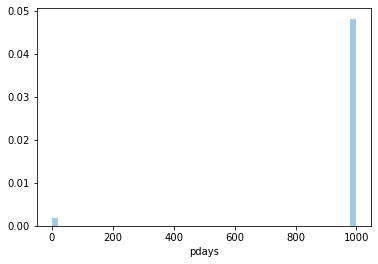

In [5]:
sns.distplot(df['pdays'])

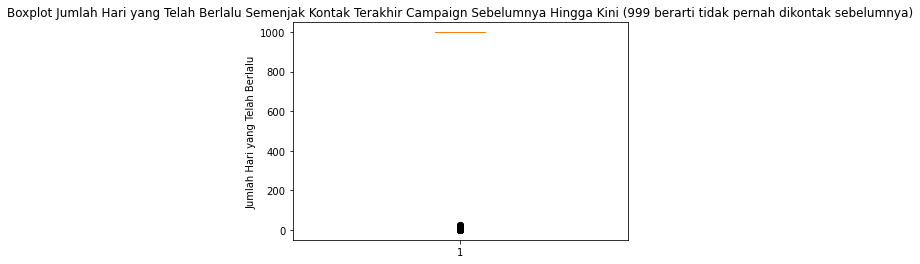

In [4]:
x = df['pdays']
plt.boxplot(x)
plt.title("Boxplot Jumlah Hari yang Telah Berlalu Semenjak Kontak Terakhir Campaign Sebelumnya Hingga Kini (999 berarti tidak pernah dikontak sebelumnya)")
plt.ylabel("Jumlah Hari yang Telah Berlalu")
plt.show()

In [37]:
(df['pdays'].describe()).round(2)

count   41,188.0
mean      962.48
std       186.91
min          0.0
25%        999.0
50%        999.0
75%        999.0
max        999.0
Name: pdays, dtype: float64

In [12]:
df[df['pdays']< 999]['pdays'].count() # jumlah data outliers nasabah dengan jeda waktu semenjak kontak terakhir dari campaign marketing sebelumnya hingga campaign marketing sekarang di bawah 999 hari

1515

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


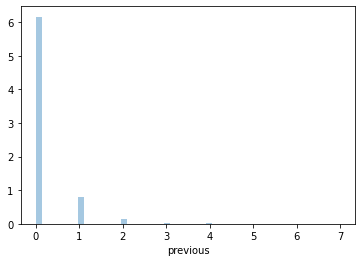

In [6]:
sns.distplot(df['previous'])

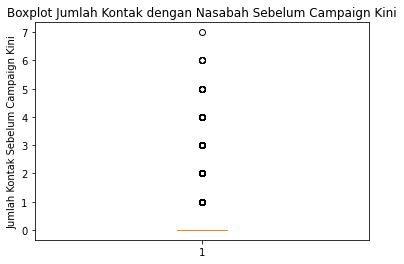

In [15]:
x = df['previous']
plt.boxplot(x)
plt.title("Boxplot Jumlah Kontak dengan Nasabah Sebelum Campaign Kini")
plt.ylabel("Jumlah Kontak Sebelum Campaign Kini")
plt.show()

In [13]:
(df['previous'].describe()).round(2)

count   41,188.0
mean        0.17
std         0.49
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          7.0
Name: previous, dtype: float64

In [14]:
df[df['previous']> 0]['previous'].count() # jumlah data outliers tentang jumlah kontak yang dilakukan sebelum campaign marketing sekarang dimulai di atas 0

5625

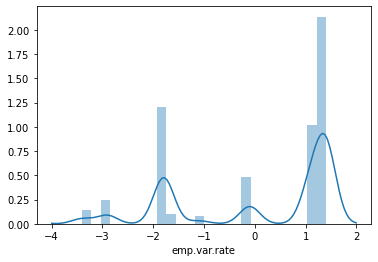

In [5]:
sns.distplot(df['emp.var.rate'])

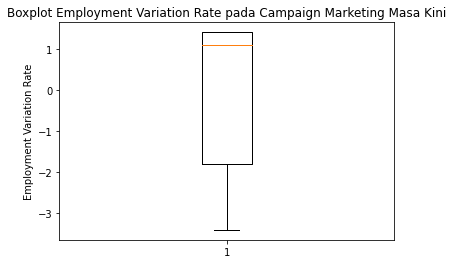

In [6]:
x = df['emp.var.rate']
plt.boxplot(x)
plt.title("Boxplot Employment Variation Rate pada Campaign Marketing Masa Kini")
plt.ylabel("Employment Variation Rate")
plt.show()

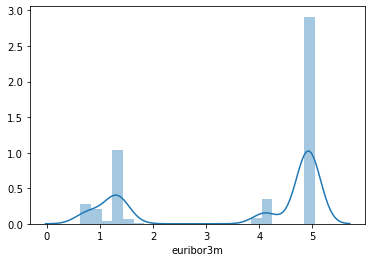

In [7]:
sns.distplot(df['euribor3m'])

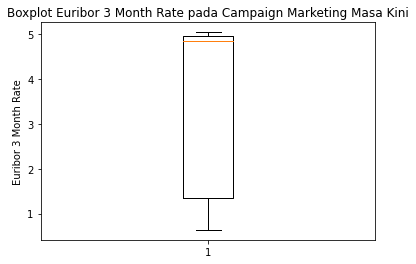

In [8]:
x = df['euribor3m']
plt.boxplot(x)
plt.title("Boxplot Euribor 3 Month Rate pada Campaign Marketing Masa Kini")
plt.ylabel("Euribor 3 Month Rate")
plt.show()

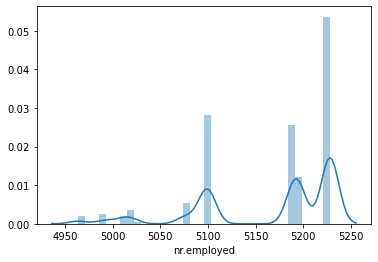

In [9]:
sns.distplot(df['nr.employed'])

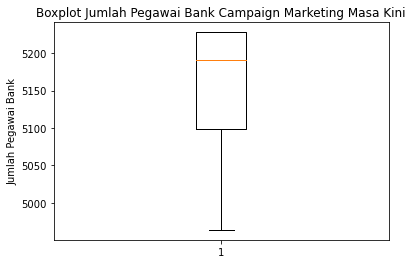

In [10]:
x = df['nr.employed']
plt.boxplot(x)
plt.title("Boxplot Jumlah Pegawai Bank Campaign Marketing Masa Kini")
plt.ylabel("Jumlah Pegawai Bank")
plt.show()

In [70]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no


In [71]:
pd.crosstab(index=df.job, columns=df.y)

y,no,yes
job,,
admin.,9070,1352
blue-collar,8616,638
entrepreneur,1332,124
housemaid,954,106
management,2596,328
retired,1286,434
self-employed,1272,149
services,3646,323
student,600,275


In [5]:
pd.crosstab(index=df.job, columns=df.y, normalize='index')

y,no,yes
job,,
admin.,0.8702744194972174,0.12972558050278257
blue-collar,0.931056840285282,0.06894315971471796
entrepreneur,0.9148351648351648,0.08516483516483517
housemaid,0.9,0.1
management,0.8878248974008208,0.1121751025991792
retired,0.7476744186046511,0.25232558139534883
self-employed,0.8951442646023927,0.10485573539760731
services,0.9186192995716805,0.08138070042831948
student,0.6857142857142857,0.3142857142857143


In [12]:
df["job"].nunique()

12

In [59]:
j = []
for i in df["job"].unique():
    j.append(df[(df["job"]==i) & (df['y'] == 'yes')]["job"].count())

j

[106, 323, 1352, 638, 730, 434, 328, 144, 149, 37, 124, 275]

In [45]:
len(df)

41188

In [60]:
persentase = []
nama = []
for i in range(0,(len(j))):
    persentase.append(j[i])
    nama.append(df["job"].unique()[i])

In [61]:
persentase

[106, 323, 1352, 638, 730, 434, 328, 144, 149, 37, 124, 275]

In [62]:
nama

['housemaid',
 'services',
 'admin.',
 'blue-collar',
 'technician',
 'retired',
 'management',
 'unemployed',
 'self-employed',
 'unknown',
 'entrepreneur',
 'student']

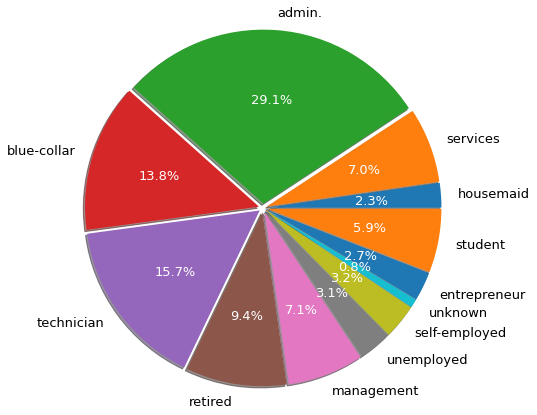

In [65]:
j = []
for i in df["job"].unique():
    j.append(df[(df["job"]==i) & (df['y'] == 'yes')]["job"].count())

persentase = []
nama = []
for i in range(0,(len(j))):
    persentase.append(j[i])
    nama.append(df["job"].unique()[i])

x, y, z = plt.pie(
    persentase,
    labels=nama,    
    startangle=0,
    shadow=True,
    radius = 2,
    textprops={
        'size' : 13 ,
        'color' : 'black'
    },
#    autopct = '%i%%'
    autopct = '%1.1f%%',
    explode = (.05, .05, .05, .05, .05, .05, .05, .05, .05, .05, .05, .05) # pemisah pie chart
)

for i in z:
    i.set_color('white')

# plt.grid(True)
plt.show()

In [72]:
pd.crosstab(index=df.marital, columns=df.y)

y,no,yes
marital,,
divorced,4136,476
married,22396,2532
single,9948,1620
unknown,68,12


In [6]:
pd.crosstab(index=df.marital, columns=df.y, normalize='index')

y,no,yes
marital,,
divorced,0.8967909800520382,0.10320901994796183
married,0.8984274711168164,0.10157252888318356
single,0.8599585062240664,0.1400414937759336
unknown,0.85,0.15


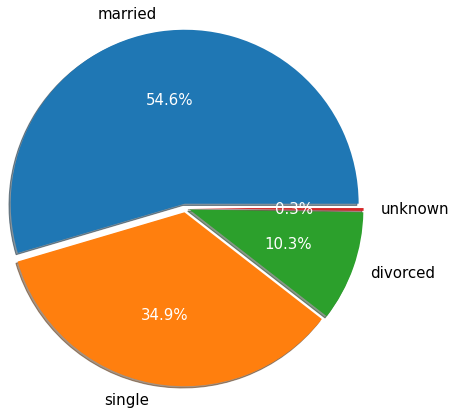

In [66]:
j = []
for i in df["marital"].unique():
    j.append(df[(df["marital"]==i) & (df['y'] == 'yes')]["marital"].count())

persentase = []
nama = []
for i in range(0,(len(j))):
    persentase.append(j[i])
    nama.append(df["marital"].unique()[i])

x, y, z = plt.pie(
    persentase,
    labels=nama,    
    startangle=0,
    shadow=True,
    radius = 2,
    textprops={
        'size' : 15 ,
        'color' : 'black'
    },
#    autopct = '%i%%'
    autopct = '%1.1f%%',
    explode = (.05, .05, .05, .05) # pemisah pie chart
)

for i in z:
    i.set_color('white')

# plt.grid(True)
plt.show()

In [73]:
pd.crosstab(index=df.education, columns=df.y)

y,no,yes
education,,
basic.4y,3748,428
basic.6y,2104,188
basic.9y,5572,473
high.school,8484,1031
illiterate,14,4
professional.course,4648,595
university.degree,10498,1670
unknown,1480,251


In [7]:
pd.crosstab(index=df.education, columns=df.y, normalize='index')

y,no,yes
education,,
basic.4y,0.8975095785440613,0.1024904214559387
basic.6y,0.9179755671902269,0.08202443280977312
basic.9y,0.9217535153019024,0.0782464846980976
high.school,0.8916447714135576,0.10835522858644246
illiterate,0.7777777777777778,0.2222222222222222
professional.course,0.8865153538050734,0.11348464619492657
university.degree,0.8627547666009204,0.13724523339907954
unknown,0.8549971114962449,0.14500288850375506


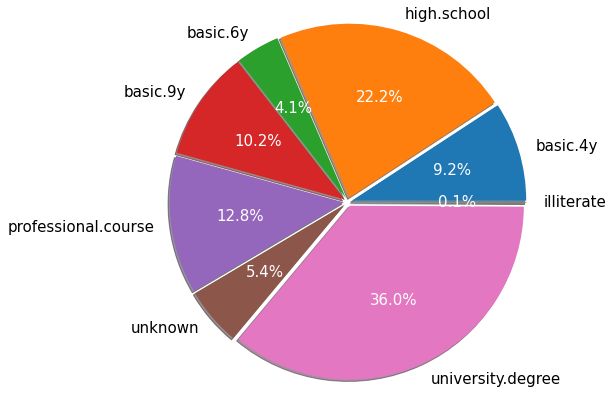

In [67]:
j = []
for i in df["education"].unique():
    j.append(df[(df["education"]==i) & (df['y'] == 'yes')]["education"].count())

persentase = []
nama = []
for i in range(0,(len(j))):
    persentase.append(j[i])
    nama.append(df["education"].unique()[i])

x, y, z = plt.pie(
    persentase,
    labels=nama,    
    startangle=0,
    shadow=True,
    radius = 2,
    textprops={
        'size' : 15 ,
        'color' : 'black'
    },
#    autopct = '%i%%'
    autopct = '%1.1f%%',
    explode = (.05, .05, .05, .05, .05, .05, .05, .05) # pemisah pie chart
)

for i in z:
    i.set_color('white')

# plt.grid(True)
plt.show()

In [74]:
pd.crosstab(index=df.default, columns=df.y)

y,no,yes
default,,
no,28391,4197
unknown,8154,443
yes,3,0


In [8]:
pd.crosstab(index=df.default, columns=df.y, normalize='index')

y,no,yes
default,,
no,0.8712102614459311,0.12878973855406897
unknown,0.9484703966499942,0.051529603350005816
yes,1.0,0.0


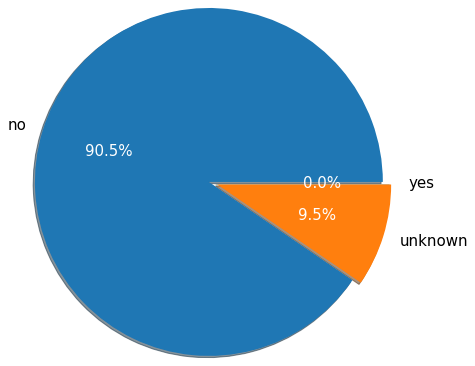

In [68]:
j = []
for i in df["default"].unique():
    j.append(df[(df["default"]==i) & (df['y'] == 'yes')]["default"].count())

persentase = []
nama = []
for i in range(0,(len(j))):
    persentase.append(j[i])
    nama.append(df["default"].unique()[i])

x, y, z = plt.pie(
    persentase,
    labels=nama,    
    startangle=0,
    shadow=True,
    radius = 2,
    textprops={
        'size' : 15 ,
        'color' : 'black'
    },
#    autopct = '%i%%'
    autopct = '%1.1f%%',
    explode = (.05, .05, .05) # pemisah pie chart
)

for i in z:
    i.set_color('white')

# plt.grid(True)
plt.show()

In [75]:
pd.crosstab(index=df.housing, columns=df.y)

y,no,yes
housing,,
no,16596,2026
unknown,883,107
yes,19069,2507


In [9]:
pd.crosstab(index=df.housing, columns=df.y, normalize='index')

y,no,yes
housing,,
no,0.8912039523144668,0.10879604768553323
unknown,0.8919191919191919,0.10808080808080808
yes,0.8838060808305525,0.11619391916944753


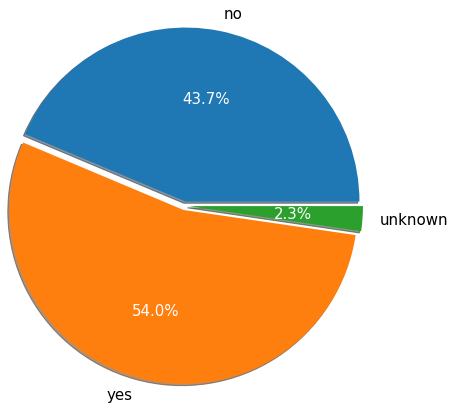

In [69]:
j = []
for i in df["housing"].unique():
    j.append(df[(df["housing"]==i) & (df['y'] == 'yes')]["housing"].count())

persentase = []
nama = []
for i in range(0,(len(j))):
    persentase.append(j[i])
    nama.append(df["housing"].unique()[i])

x, y, z = plt.pie(
    persentase,
    labels=nama,    
    startangle=0,
    shadow=True,
    radius = 2,
    textprops={
        'size' : 15 ,
        'color' : 'black'
    },
#    autopct = '%i%%'
    autopct = '%1.1f%%',
    explode = (.05, .05, .05) # pemisah pie chart
)

for i in z:
    i.set_color('white')

# plt.grid(True)
plt.show()

In [76]:
pd.crosstab(index=df.loan, columns=df.y)

y,no,yes
loan,,
no,30100,3850
unknown,883,107
yes,5565,683


In [10]:
pd.crosstab(index=df.loan, columns=df.y, normalize='index')

y,no,yes
loan,,
no,0.8865979381443299,0.1134020618556701
unknown,0.8919191919191919,0.10808080808080808
yes,0.890685019206146,0.10931498079385403


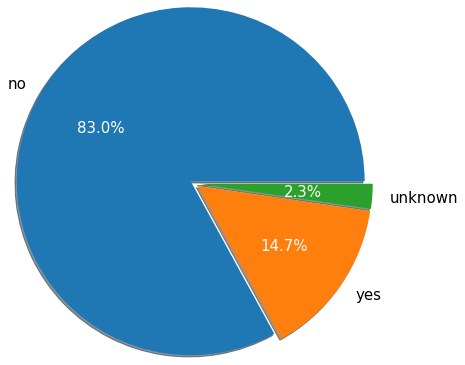

In [70]:
j = []
for i in df["loan"].unique():
    j.append(df[(df["loan"]==i) & (df['y'] == 'yes')]["loan"].count())

persentase = []
nama = []
for i in range(0,(len(j))):
    persentase.append(j[i])
    nama.append(df["loan"].unique()[i])

x, y, z = plt.pie(
    persentase,
    labels=nama,    
    startangle=0,
    shadow=True,
    radius = 2,
    textprops={
        'size' : 15 ,
        'color' : 'black'
    },
#    autopct = '%i%%'
    autopct = '%1.1f%%',
    explode = (.05, .05, .05) # pemisah pie chart
)

for i in z:
    i.set_color('white')

# plt.grid(True)
plt.show()

In [77]:
pd.crosstab(index=df.contact, columns=df.y)

y,no,yes
contact,,
cellular,22291,3853
telephone,14257,787


In [11]:
pd.crosstab(index=df.contact, columns=df.y, normalize='index')

y,no,yes
contact,,
cellular,0.852623929008568,0.14737607099143207
telephone,0.9476867854294071,0.05231321457059293


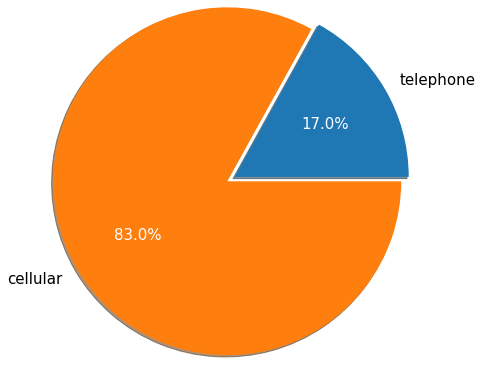

In [72]:
j = []
for i in df["contact"].unique():
    j.append(df[(df["contact"]==i) & (df['y'] == 'yes')]["contact"].count())

persentase = []
nama = []
for i in range(0,(len(j))):
    persentase.append(j[i])
    nama.append(df["contact"].unique()[i])

x, y, z = plt.pie(
    persentase,
    labels=nama,    
    startangle=0,
    shadow=True,
    radius = 2,
    textprops={
        'size' : 15 ,
        'color' : 'black'
    },
#    autopct = '%i%%'
    autopct = '%1.1f%%',
    explode = (.05, .05) # pemisah pie chart
)

for i in z:
    i.set_color('white')

# plt.grid(True)
plt.show()

In [78]:
pd.crosstab(index=df.poutcome, columns=df.y)

y,no,yes
poutcome,,
failure,3647,605
nonexistent,32422,3141
success,479,894


In [12]:
pd.crosstab(index=df.poutcome, columns=df.y, normalize='index')

y,no,yes
poutcome,,
failure,0.8577140169332079,0.1422859830667921
nonexistent,0.9116778674465034,0.08832213255349661
success,0.348871085214858,0.651128914785142


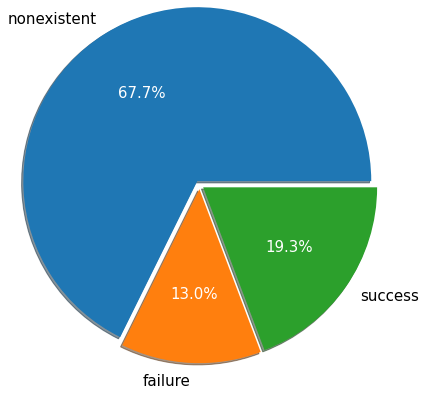

In [73]:
j = []
for i in df["poutcome"].unique():
    j.append(df[(df["poutcome"]==i) & (df['y'] == 'yes')]["poutcome"].count())

persentase = []
nama = []
for i in range(0,(len(j))):
    persentase.append(j[i])
    nama.append(df["poutcome"].unique()[i])

x, y, z = plt.pie(
    persentase,
    labels=nama,    
    startangle=0,
    shadow=True,
    radius = 2,
    textprops={
        'size' : 15 ,
        'color' : 'black'
    },
#    autopct = '%i%%'
    autopct = '%1.1f%%',
    explode = (.05, .05, .05) # pemisah pie chart
)

for i in z:
    i.set_color('white')

# plt.grid(True)
plt.show()

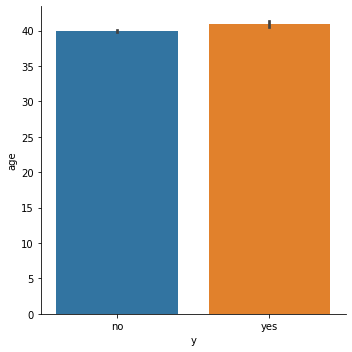

In [68]:
sns.catplot(x='y', y='age', data = df, kind = 'bar', aspect = 1)

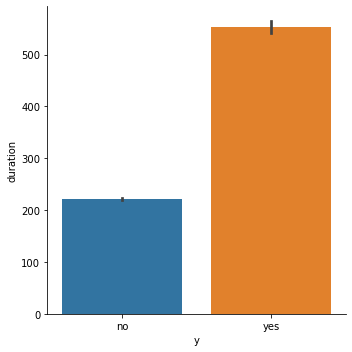

In [107]:
sns.catplot(x='y', y='duration', data = df, kind = 'bar', aspect = 1)

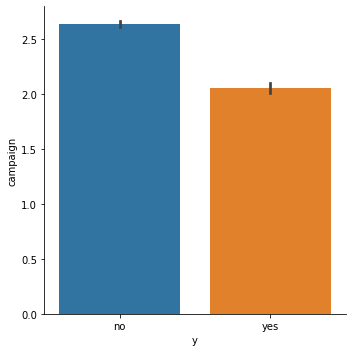

In [108]:
sns.catplot(x='y', y='campaign', data = df, kind = 'bar', aspect = 1)

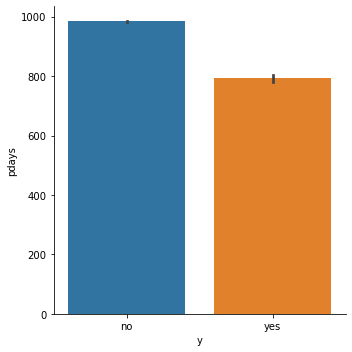

In [109]:
sns.catplot(x='y', y='pdays', data = df, kind = 'bar', aspect = 1)

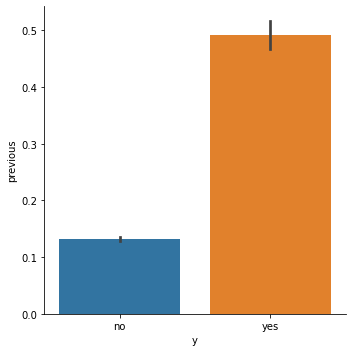

In [110]:
sns.catplot(x='y', y='previous', data = df, kind = 'bar', aspect = 1)

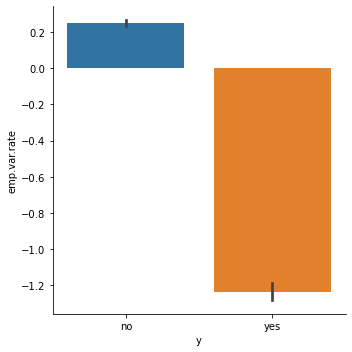

In [111]:
sns.catplot(x='y', y='emp.var.rate', data = df, kind = 'bar', aspect = 1)

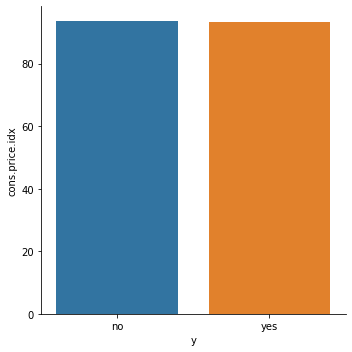

In [112]:
sns.catplot(x='y', y='cons.price.idx', data = df, kind = 'bar', aspect = 1)

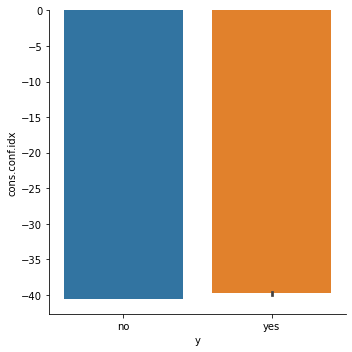

In [113]:
sns.catplot(x='y', y='cons.conf.idx', data = df, kind = 'bar', aspect = 1)

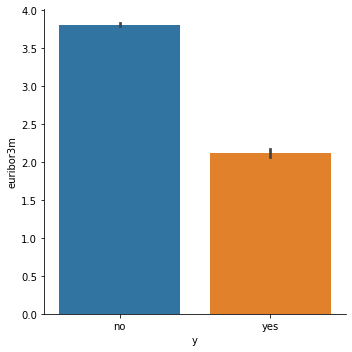

In [114]:
sns.catplot(x='y', y='euribor3m', data = df, kind = 'bar', aspect = 1)

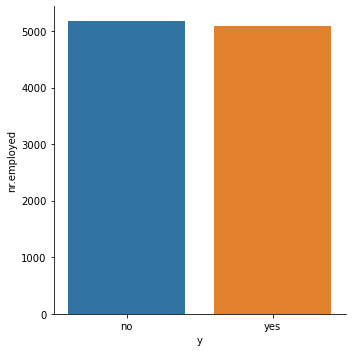

In [80]:
sns.catplot(x='y', y='nr.employed', data = df, kind = 'bar', aspect = 1)

In [50]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no


In [38]:
df_dummy = df.copy()

In [39]:
df_dummy.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,"5,191.0",no


In [40]:
df_dummy['y'] = df_dummy['y'].map({'no' : 0, 'yes' : 1})

In [29]:
df_dummy = pd.get_dummies(data=df_dummy, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'])

In [30]:
df_dummy.head()

,age,month,day_of_week,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,may,mon,261,1,999,0,1.1,93.994,-36.4,4.857,"5,191.0",0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0
1,57,may,mon,149,1,999,0,1.1,93.994,-36.4,4.857,"5,191.0",0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0
2,37,may,mon,226,1,999,0,1.1,93.994,-36.4,4.857,"5,191.0",0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0
3,40,may,mon,151,1,999,0,1.1,93.994,-36.4,4.857,"5,191.0",0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0
4,56,may,mon,307,1,999,0,1.1,93.994,-36.4,4.857,"5,191.0",0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0


In [31]:
dummy_corr = round(df_dummy.corr(),2)
dummy_corr['y']

age                              0.03
duration                         0.41
campaign                        -0.07
pdays                           -0.32
previous                         0.23
emp.var.rate                     -0.3
cons.price.idx                  -0.14
cons.conf.idx                    0.05
euribor3m                       -0.31
nr.employed                     -0.35
y                                 1.0
job_admin.                       0.03
job_blue-collar                 -0.07
job_entrepreneur                -0.02
job_housemaid                   -0.01
job_management                   -0.0
job_retired                      0.09
job_self-employed                -0.0
job_services                    -0.03
job_student                      0.09
job_technician                  -0.01
job_unemployed                   0.01
job_unknown                      -0.0
marital_divorced                -0.01
marital_married                 -0.04
marital_single                   0.05
marital_unkn

#### Dari nilai korelasi yang didapatkan terhadap 'y', feature yang digunakan untuk pemodelan adalah feature dengan |nilai korelasi| = 0.2 ke atas, yaitu 'duration', 'pdays', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed', dan 'poutcome' 

## Data Cleaning

In [3]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Tidak ada data yang bernilai Null atau NaN, sehingga langkah penanggulangan tidak perlu

# Feature Engineering and Feature Selection

In [3]:
df_clean = df.copy()
df_clean = df_clean.drop(columns= ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign','cons.price.idx', 'cons.conf.idx'])

In [4]:
df_clean.head()

,duration,pdays,previous,poutcome,emp.var.rate,euribor3m,nr.employed,y
0,261,999,0,nonexistent,1.1,4.857,"5,191.0",no
1,149,999,0,nonexistent,1.1,4.857,"5,191.0",no
2,226,999,0,nonexistent,1.1,4.857,"5,191.0",no
3,151,999,0,nonexistent,1.1,4.857,"5,191.0",no
4,307,999,0,nonexistent,1.1,4.857,"5,191.0",no


## Export File

In [5]:
df_clean.to_csv(path_or_buf="C:/Users/ASUS/visual_studio_code/final_project/dataset/bank-additional-full_clean.csv")